<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
#使用 pandas 和 numpy 进行数据处理
import pandas as pd
import numpy as np

#使用 matplotlib 和 seaborn 进行绘制
import matplotlib.pyplot as plt
import seaborn as sns

#禁止 pandas 的编译警告
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

In [3]:
# 读入bureau属性
bureau = pd.read_csv('./data/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [4]:
# 按照客户id (SK_ID_CURR) 进行Groupeby操作，计算历史贷款总数，并将SK_ID_BUREAU列重命名为previous_loan_counts
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index = False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [5]:
# 将计算得到的previous_loan_counts列加入原先的训练数据application_train.csv
train = pd.read_csv('./data/application_train.csv')
train = train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')# 左连接，左侧DataFrame取全部，右侧DataFrame取部分

# 填补缺失值
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [6]:
# 绘制根据不同目标值着色的变量分布
def kde_target(var_name, df):
    
    # 计算变量与目标值之间的皮尔森相关系数
    corr = df['TARGET'].corr(df[var_name])
    
    # 计算偿还或未偿还贷款数据的中位数
    avg_repaid = df.ix[df['TARGET'] == 0, var_name].median()# df.ix：索引函数，既可以通过行号索引，也可以通过行标签索引
    avg_not_repaid = df.ix[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # 绘制偿还或未偿还贷款数据的分布
    sns.kdeplot(df.ix[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # 标签绘制
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();# 显示图例
    
    # 输出皮尔森相关系数
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # 输出均值
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

ValueError: array must not contain infs or NaNs

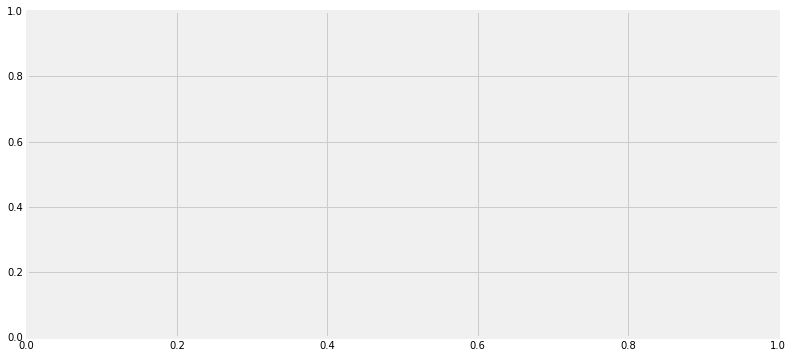

In [7]:
kde_target('EXT_SOURCE_3', train)